In [1]:
%load_ext autoreload
%autoreload 2
%cd '../HOTS'
%matplotlib inline

/home/antoine/hots/HOTS/HOTS


In [3]:
import tonic
from mix_TimeSurface import TimeSurface
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np

def printfig(fig, name):
    dpi_exp = None
    bbox = 'tight'
    path = '/fig/'
    fig.savefig(path+name, dpi = dpi_exp, bbox_inches=bbox)

In [70]:
learningset = tonic.datasets.POKERDVS(save_to='../Data/', train = False,
                                transform=None)
loader = tonic.datasets.DataLoader(learningset, shuffle=True)

Using downloaded and verified file: ../Data/pips_test.tar.gz
Extracting ../Data/pips_test.tar.gz to ../Data/


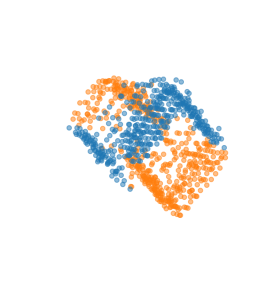

In [149]:
        target_event = 1000
        X_on = []
        Y_on = []
        T_on = []
        X_off = []
        Y_off = []
        T_off = []
        iev = 100
        events, target = next(iter(loader))
        while iev<target_event:
            x,y,t,p = events[0][iev][learningset.ordering.find("x")].item(), \
                    events[0][iev][learningset.ordering.find("y")].item(), \
                    events[0][iev][learningset.ordering.find("t")].item(), \
                    events[0][iev][learningset.ordering.find("p")].item()
            if p:
                X_on.append(x)
                Y_on.append(abs(learningset.sensor_size[1]-y))
                T_on.append(t)
            else:
                X_off.append(x)
                Y_off.append(abs(learningset.sensor_size[1]-y))
                T_off.append(t)
            iev+=1
        fig = plt.figure(figsize=(10,5))
        sub1 = fig.add_subplot(1,2,1, projection="3d")
        sub1.scatter(T_on, X_on, Y_on, cmap= plt.cm.plasma, alpha=0.5)
        sub1.scatter(T_off, X_off, Y_off, cmap= plt.cm.plasma, alpha=0.5)
        #sub1.arrow([0,max(T_off)], [0,0], [0,0])
        sub1.view_init(10,-40)
        sub1.grid(b = None)
        sub1.set_xlabel('time')
        sub1.axis('off')
        plt.show()

In [ ]:
printfig(fig, 'flux.png')

In [5]:
target_event = 2000
TS = TimeSurface(R=2,tau=5*10e3,camsize=[34,34])
events, target = next(iter(loader))
flxT = TS.spatpmat.copy()
iev = 0
while iev<target_event:
    x,y,t,p = events[0][iev][learningset.ordering.find("x")].item(), \
                events[0][iev][learningset.ordering.find("y")].item(), \
                events[0][iev][learningset.ordering.find("t")].item(), \
                events[0][iev][learningset.ordering.find("p")].item(),
    flxT[p,x,y] = t
    ts, activ = TS.addevent(x,y,t,p)
    iev+=1

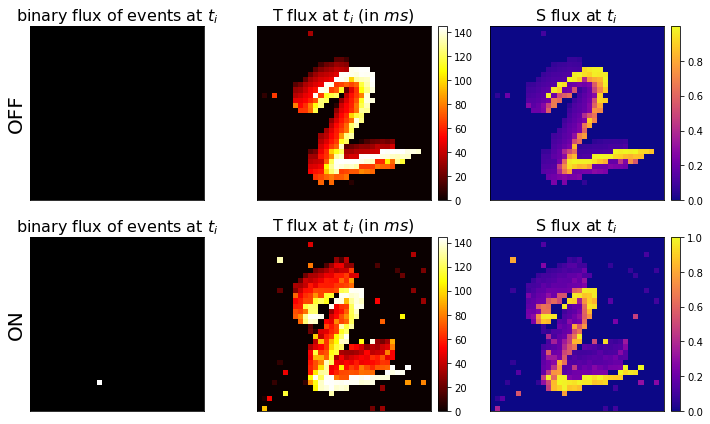

In [6]:
polaritiz = ['OFF','ON']
gamma = 1
fig, axs = plt.subplots(2,3,figsize=(10,6))

Ti = np.zeros(learningset.sensor_size)
singev = axs[abs(p-1),0].imshow(Ti.T, cmap='gray')
axs[abs(p-1),0].set_title('binary flux of events at $t_i$', fontsize=16)
axs[abs(p-1),0].set_ylabel(f'{polaritiz[abs(p-1)]}', fontsize=20)
axs[abs(p-1),0].set_xticks(())
axs[abs(p-1),0].set_yticks(())

Ti[x,y] = 1
singev = axs[p,0].imshow(Ti.T, cmap='gray')
axs[p,0].set_title('binary flux of events at $t_i$', fontsize=16)
axs[p,0].set_ylabel(f'{polaritiz[p]}', fontsize=20)
axs[p,0].set_xticks(())
axs[p,0].set_yticks(())

for p in [0,1]:
    T = axs[p,1].imshow(flxT[p].T*1e-3, cmap='hot')
    axs[p,1].set_title('T flux at $t_i$ (in $ms$)', fontsize=16)
    axs[p,1].set_xticks(())
    axs[p,1].set_yticks(())
    plt.colorbar(T, ax=axs[p,1], fraction=0.046, pad=0.04);
    
    S = axs[p,2].imshow(TS.spatpmat[p].T, cmap=plt.cm.plasma)
    axs[p,2].set_title('S flux at $t_i$', fontsize=16)
    axs[p,2].set_xticks(())
    axs[p,2].set_yticks(())
    plt.colorbar(S, ax=axs[p,2], fraction=0.046, pad=0.04);
    
fig.tight_layout()

In [46]:
printfig(fig, 'flux.png')